In [1]:
import json
import os
# test out the world
import matplotlib as plt
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from vocabulary import *
from object_vocabulary import *
from world import *
from grammer import *
from simulator import *
from relation_graph import *
import logging
import torch
import random
import math
from collections import OrderedDict
def isnotebook():
    try:
        shell = get_ipython().__class__.__name__
        if shell == 'ZMQInteractiveShell':
            return True   # Jupyter notebook or qtconsole
        elif shell == 'TerminalInteractiveShell':
            return False  # Terminal running IPython
        else:
            return False  # Other type (?)
    except NameError:
        return False      # Probably standard Python interpreter
if isnotebook():
    device = torch.device("cpu")
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

FORMAT = "%(asctime)-15s %(message)s"
logging.basicConfig(format=FORMAT, level=logging.INFO,
                    datefmt="%Y-%m-%d %H:%M")
logger = logging.getLogger(__name__)

import os
os.environ['QT_QPA_PLATFORM']='offscreen'

# test out the vocabulary
intransitive_verbs = ["walk"]
transitive_verbs = ["push", "pull"]
adverbs = ["while zigzagging", "while spinning", "cautiously", "hesitantly"]
nouns = ["circle", "cylinder", "square", "box"]
color_adjectives = ["red", "blue", "green", "yellow"]
size_adjectives = ["big", "small"]
relative_pronouns = ["that is"]
relation_clauses = ["in the same row as", 
                    "in the same column as", 
                    "in the same color as", 
                    "in the same shape as", 
                    "in the same size as",
                    "inside of"]
vocabulary = Vocabulary.initialize(intransitive_verbs=intransitive_verbs,
                                   transitive_verbs=transitive_verbs, adverbs=adverbs, nouns=nouns,
                                   color_adjectives=color_adjectives,
                                   size_adjectives=size_adjectives, 
                                   relative_pronouns=relative_pronouns, 
                                   relation_clauses=relation_clauses)

# test out the object vocab
min_object_size = 1
max_object_size = 4
object_vocabulary = ObjectVocabulary(shapes=vocabulary.get_semantic_shapes(),
                                     colors=vocabulary.get_semantic_colors(),
                                     min_size=min_object_size, max_size=max_object_size)
# object_vocabulary.generate_objects()
external_data_dir = "../../data-files/"

### Data Loader
Loading all created data long with gSCAN into memory.

In [2]:
gSCAN_data_file = "gSCAN-compositional_splits/dataset.txt"
gSCAN_data_json = json.load(open(os.path.join("../../data-files-updated/", gSCAN_data_file)))

In [3]:
p1_path_to_data = "../../data-files-updated/ReaSCAN-compositional-p1/data-compositional-splits.txt"
logger.info(f"Reading dataset from file: {p1_path_to_data}...")
p1_data_json = json.load(open(p1_path_to_data, "r"))

p2_path_to_data = "../../data-files-updated/ReaSCAN-compositional-p2/data-compositional-splits.txt"
logger.info(f"Reading dataset from file: {p2_path_to_data}...")
p2_data_json = json.load(open(p2_path_to_data, "r"))

p3_path_to_data = "../../data-files-updated/ReaSCAN-compositional-p3/data-compositional-splits.txt"
logger.info(f"Reading dataset from file: {p3_path_to_data}...")
p3_data_json = json.load(open(p3_path_to_data, "r"))

p3_rd_path_to_data = "../../data-files-updated/ReaSCAN-compositional-p3-rd/data-compositional-splits.txt"
logger.info(f"Reading dataset from file: {p3_rd_path_to_data}...")
p3_rd_data_json = json.load(open(p3_rd_path_to_data, "r"))

2021-06-06 11:33 Reading dataset from file: ../../data-files-updated/ReaSCAN-compositional-p1/data-compositional-splits.txt...
2021-06-06 11:33 Reading dataset from file: ../../data-files-updated/ReaSCAN-compositional-p2/data-compositional-splits.txt...
2021-06-06 11:34 Reading dataset from file: ../../data-files-updated/ReaSCAN-compositional-p3/data-compositional-splits.txt...
2021-06-06 11:36 Reading dataset from file: ../../data-files-updated/ReaSCAN-compositional-p3-rd/data-compositional-splits.txt...


#### 1. Action Sequence Length Analyses
Let us see if aciton sequence is similarily distributed across these tasks. We don't want them to distribute differently, as we know longer sequence is definitely harder.

In [4]:
gSCAN_action_lengths = []
for i in range(0, len(gSCAN_data_json["examples"]["train"])):
    gSCAN_action_lengths.append(len(gSCAN_data_json["examples"]["train"][i]["target_commands"].split(",")))

# Let us look at sequence length in each training split of these generated sets.
p1_action_lengths = []
for i in range(0, len(p1_data_json["examples"]["train"])):
    p1_action_lengths.append(len(p1_data_json["examples"]["train"][i]["target_commands"].split(",")))
    
p2_action_lengths = []
for i in range(0, len(p2_data_json["examples"]["train"])):
    p2_action_lengths.append(len(p2_data_json["examples"]["train"][i]["target_commands"].split(",")))
    
p3_action_lengths = []
for i in range(0, len(p3_data_json["examples"]["train"])):
    p3_action_lengths.append(len(p3_data_json["examples"]["train"][i]["target_commands"].split(",")))
    
p3_rd_action_lengths = []
for i in range(0, len(p3_rd_data_json["examples"]["train"])):
    p3_rd_action_lengths.append(len(p3_rd_data_json["examples"]["train"][i]["target_commands"].split(",")))

In [5]:
# dump the length for checkpoint!
action_lengths = {
    "gSCAN_action_lengths" : gSCAN_action_lengths,
    "p1_action_lengths" : p1_action_lengths,
    "p2_action_lengths" : p2_action_lengths,
    "p3_action_lengths" : p3_action_lengths,
    "p3_rd_action_lengths" : p3_rd_action_lengths,
}
with open("../../data-files-updated/Analysis-Result/action_lengths.txt", "w") as fd:
    json.dump(action_lengths, fd, indent=4)

In [10]:
action_lengths = json.load(open("../../data-files-updated/Analysis-Result/action_lengths.txt", "r"))
gSCAN_action_lengths = action_lengths['gSCAN_action_lengths']
p1_action_lengths = action_lengths['p1_action_lengths']
p2_action_lengths = action_lengths['p2_action_lengths']
p3_action_lengths = action_lengths['p3_action_lengths']
p3_rd_action_lengths = action_lengths['p3_rd_action_lengths']

from collections import Counter
bin_width = 10
max_bound = (max(p3_rd_action_lengths)//bin_width)+1
upper_bound = (50//bin_width)+1
def get_freq_list(action_lengths, bin_width=bin_width, upper_bound=upper_bound):
    _freq = Counter()
    for x in action_lengths:
        _freq[(x - 1) // bin_width] += 1
    _freq_list = []
    for i in range(0, upper_bound):
        if i in _freq:
            _freq_list += [_freq[i]] 
        else:
            _freq_list += [0]
    # get the last one combined with everything above
    for i in range(upper_bound, max_bound):
        if i in _freq:
            _freq_list[upper_bound-1] += _freq[i]

    return _freq_list

gSCAN_freq_list = get_freq_list(gSCAN_action_lengths, upper_bound=upper_bound)
p1_freq_list = get_freq_list(p1_action_lengths, upper_bound=upper_bound)
p2_freq_list = get_freq_list(p2_action_lengths, upper_bound=upper_bound)
p3_freq_list = get_freq_list(p3_action_lengths, upper_bound=upper_bound)
p3_rd_freq_list = get_freq_list(p3_rd_action_lengths, upper_bound=upper_bound)

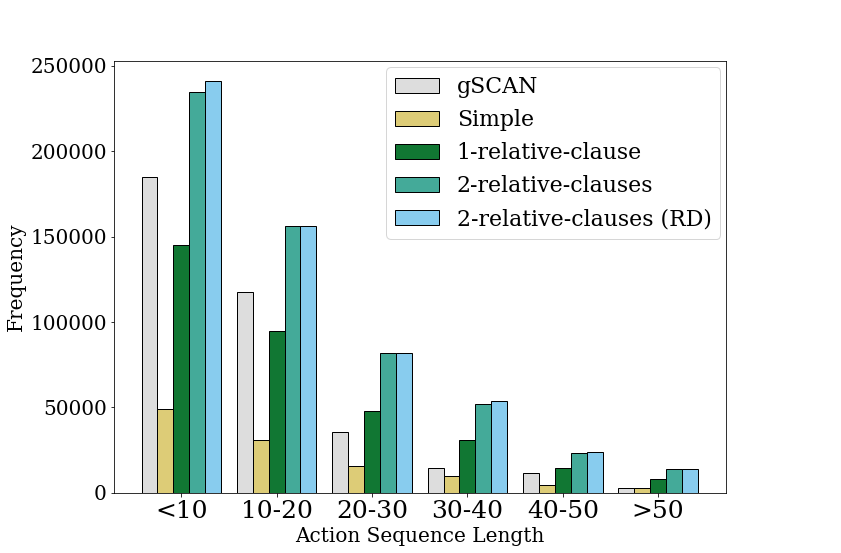

In [13]:
import numpy as np
import matplotlib.pyplot as plt
# plt.style.use("ggplot")

plt.rcParams["font.family"] = "DejaVu Serif"
font = {'family' : 'DejaVu Serif',
        'size'   : 20}
plt.rc('font', **font)
with plt.rc_context({'axes.edgecolor':'black', 'xtick.color':'black', 'ytick.color':'black', 'figure.facecolor':'white'}):

    X = np.arange(len(p2_freq_list))
    X = X*1.5
    fig = plt.figure(figsize=(8.5, 6))
    ax = fig.add_axes([0,0,1,1])
#     plt.grid(color='grey', linestyle='-.', linewidth=0.7)
    ax.bar(X + 0.00, gSCAN_freq_list, color = '#DDDDDD', width = 0.25, label='gSCAN', alpha=1, edgecolor='k', linewidth=1)
    ax.bar(X + 0.25, p1_freq_list, color = '#ddcc77', width = 0.25, label='Simple', alpha=1, edgecolor='k', linewidth=1)
    ax.bar(X + 0.50, p2_freq_list, color = '#117733', width = 0.25, label='1-relative-clause', alpha=1, edgecolor='k', linewidth=1)
    ax.bar(X + 0.75, p3_freq_list, color = '#44aa99', width = 0.25, label='2-relative-clauses', alpha=1, edgecolor='k', linewidth=1)
    ax.bar(X + 1.0, p3_rd_freq_list, color = '#88ccee', width = 0.25, label='2-relative-clauses (RD)', alpha=1, edgecolor='k', linewidth=1)
    # plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    fig.legend(loc='upper right', bbox_to_anchor=(1.195,1.15), facecolor='white',
               ncol=1, fancybox=True, shadow=False, fontsize=22)
    ax.set_ylabel('Frequency', color = "black")
    ax.set_xlabel('Action Sequence Length', color = "black")

    plt.xticks(X+0.5, ["<10", "10-20", "20-30", "30-40", "40-50", ">50"], fontsize=25)
    ax.set_facecolor("white")
    # plt.show()
    plt.savefig("../../data-files-updated/Analysis-Result/action_sequence_length",dpi=1000, bbox_inches='tight')

# ReaSCAN Analyses
This file contains statistics analysis of the generated ReaSCAN by comparing to gSCAN.

In [175]:
ReaSCAN_data_file = "ReaSCAN-compositional-p3-rd/data-compositional-splits.txt"
ReaSCAN_data_json = json.load(open(os.path.join(external_data_dir, ReaSCAN_data_file)))

In [187]:
example = ReaSCAN_data_json["examples"]["train"][random.randint(0, len(ReaSCAN_data_json["examples"]["train"])-1)]
print(example["command"])

walk,to,a,red,object,that,is,inside,of,the,small,box,and,in,the,same,size,as,the,red,circle,hesitantly


In [188]:
example

{'command': 'walk,to,a,red,object,that,is,inside,of,the,small,box,and,in,the,same,size,as,the,red,circle,hesitantly',
 'grammer_pattern': '$OBJ_0 ^ $OBJ_1 & $OBJ_2',
 'meaning': 'walk,to,a,red,object,that,is,inside,of,the,small,box,and,in,the,same,size,as,the,red,circle,hesitantly',
 'derivation': '$OBJ_0 ^ $OBJ_1 & $OBJ_2',
 'situation': {'grid_size': 6,
  'agent_position': {'row': '5', 'column': '5'},
  'agent_direction': 0,
  'target_object': {'vector': '010001001000',
   'position': {'row': '3', 'column': '4'},
   'object': {'shape': 'cylinder', 'color': 'red', 'size': '2'}},
  'distance_to_target': '3',
  'direction_to_target': 'nw',
  'placed_objects': {'0': {'vector': '010001001000',
    'position': {'row': '3', 'column': '4'},
    'object': {'shape': 'cylinder', 'color': 'red', 'size': '2'}},
   '1': {'vector': '100000011000',
    'position': {'row': '3', 'column': '4'},
    'object': {'shape': 'box', 'color': 'red', 'size': '1'}},
   '2': {'vector': '010010001000',
    'positi

command: push,the,big,blue,circle,cautiously


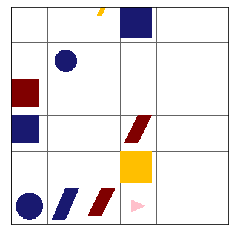

In [56]:
example = ReaSCAN_data_json["examples"]["train"][random.randint(0, len(ReaSCAN_data_json["examples"]["train"])-1)]
command = example["command"]
print(f"command: {command}")
situation = example["situation"]
world = World(grid_size=6, colors=vocabulary.get_semantic_colors(),
              object_vocabulary=object_vocabulary,
              shapes=vocabulary.get_semantic_shapes(),
              save_directory="./tmp/")
world.clear_situation()
for obj_idx, obj in situation["placed_objects"].items():
    world.place_object(
        Object(size=int(obj["object"]["size"]), color=obj["object"]["color"], shape=obj["object"]["shape"]), 
        position=Position(row=int(obj["position"]["row"]), column=int(obj["position"]["column"]))
    )
world.place_agent_at(
    Position(
        row=int(situation["agent_position"]["row"]), 
        column=int(situation["agent_position"]["column"])
))
_ = world.render_simple()

In [15]:
import json
import os

external_data_dir = "../../data-files/"
ReaSCAN_data_file = "ReaSCAN-compositional/data-compositional-splits.txt"
ReaSCAN_data_json = json.load(open(os.path.join(external_data_dir, ReaSCAN_data_file)))

In [16]:
# Data splits
for split_name, examples in ReaSCAN_data_json["examples"].items():
    print(f"SPLIT: {split_name}, COUNT: {len(examples)}")

SPLIT: train, COUNT: 352392
SPLIT: novel_inside_of_as_yellow_box, COUNT: 15950
SPLIT: gscan_yellow_square_command_target_only, COUNT: 21801
SPLIT: gscan_yellow_square_command, COUNT: 76979
SPLIT: gscan_red_box_visual, COUNT: 52433
SPLIT: novel_green_circle_box_coexist_box_shape, COUNT: 13700
SPLIT: gscan_small_cylinder_command_target_only, COUNT: 31867
SPLIT: novel_yellow_square_blue_circle_coexist_shape, COUNT: 8450
SPLIT: novel_same_shape_is_inside_coexist_relation, COUNT: 4698
SPLIT: dev, COUNT: 19282
SPLIT: test, COUNT: 3716


In [17]:
# Data splits per command pattern
for split_name, examples in ReaSCAN_data_json["examples"].items():
    p1_c = 0
    p2_c = 0
    p3_c = 0
    for example in examples:
        if example["derivation"] == '$OBJ_0 ^ $OBJ_1 & $OBJ_2':
            p3_c += 1
        elif example["derivation"] == '$OBJ_0 ^ $OBJ_1':
            p2_c += 1
        elif example["derivation"] == '$OBJ_0':
            p1_c += 1
    print(f"SPLIT: {split_name}, P1_COUNT: {p1_c}, P2_COUNT: {p2_c}, P3_COUNT: {p3_c}")

SPLIT: train, P1_COUNT: 1743, P2_COUNT: 34700, P3_COUNT: 315949
SPLIT: novel_inside_of_as_yellow_box, P1_COUNT: 0, P2_COUNT: 1600, P3_COUNT: 14350
SPLIT: gscan_yellow_square_command_target_only, P1_COUNT: 150, P2_COUNT: 2700, P3_COUNT: 18951
SPLIT: gscan_yellow_square_command, P1_COUNT: 150, P2_COUNT: 6100, P3_COUNT: 70729
SPLIT: gscan_red_box_visual, P1_COUNT: 0, P2_COUNT: 2211, P3_COUNT: 50222
SPLIT: novel_green_circle_box_coexist_box_shape, P1_COUNT: 0, P2_COUNT: 0, P3_COUNT: 13700
SPLIT: gscan_small_cylinder_command_target_only, P1_COUNT: 250, P2_COUNT: 3450, P3_COUNT: 28167
SPLIT: novel_yellow_square_blue_circle_coexist_shape, P1_COUNT: 0, P2_COUNT: 500, P3_COUNT: 7950
SPLIT: novel_same_shape_is_inside_coexist_relation, P1_COUNT: 0, P2_COUNT: 0, P3_COUNT: 4698
SPLIT: dev, P1_COUNT: 90, P2_COUNT: 1899, P3_COUNT: 17293
SPLIT: test, P1_COUNT: 17, P2_COUNT: 372, P3_COUNT: 3327


In [10]:
ReaSCAN_data_json["examples"]["train"][0]

{'command': 'push,the,object,that,is,in,the,same,row,as,the,small,green,cylinder,and,in,the,same,column,as,a,big,cylinder',
 'grammer_pattern': '$OBJ_0 ^ $OBJ_1 & $OBJ_2',
 'meaning': 'push,the,object,that,is,in,the,same,row,as,the,small,green,cylinder,and,in,the,same,column,as,a,big,cylinder',
 'derivation': '$OBJ_0 ^ $OBJ_1 & $OBJ_2',
 'situation': {'grid_size': 6,
  'agent_position': {'row': '2', 'column': '4'},
  'agent_direction': 0,
  'target_object': {'vector': '000101000001',
   'position': {'row': '4', 'column': '4'},
   'object': {'shape': 'cylinder', 'color': 'yellow', 'size': '4'}},
  'distance_to_target': '2',
  'direction_to_target': 's',
  'placed_objects': {'0': {'vector': '000101000001',
    'position': {'row': '4', 'column': '4'},
    'object': {'shape': 'cylinder', 'color': 'yellow', 'size': '4'}},
   '1': {'vector': '100001000010',
    'position': {'row': '4', 'column': '0'},
    'object': {'shape': 'cylinder', 'color': 'green', 'size': '1'}},
   '2': {'vector': '00

Distractors type analysis

In [78]:
# we need to load P1 P2 P3 separately and combine to get the most accurate data distribution!
# p1_path_to_data = "../../data-files/ReaSCAN-compositional-p1/data-train.txt"
# logger.info(f"Reading dataset from file: {p1_path_to_data}...")
# p1_data_json = json.load(open(p1_path_to_data, "r"))

# p2_path_to_data = "../../data-files/ReaSCAN-compositional-p2/data-train.txt"
# logger.info(f"Reading dataset from file: {p2_path_to_data}...")
# p2_data_json = json.load(open(p2_path_to_data, "r"))

# p3_path_to_data = "../../data-files/ReaSCAN-compositional-p3/data-train.txt"
# logger.info(f"Reading dataset from file: {p3_path_to_data}...")
# p3_data_json = json.load(open(p3_path_to_data, "r"))

# consolidate
p3_data_json["examples"]["train"].extend(p2_data_json["examples"]["train"])
p3_data_json["examples"]["train"].extend(p1_data_json["examples"]["train"])

In [79]:
def extract_distractor_type_stats(
    examples, 
    pattern='$OBJ_0 ^ $OBJ_1 & $OBJ_2'
):
    total_count = 0
    full_relation_distractor = 0
    has_relation_distractor = 0
    has_attribute_distractor = 0
    has_isomorphism_distractor = 0
    has_random_distractor = 0
    for split, examples in examples.items():
        for example in examples:
            if example['grammer_pattern'] == pattern:
                total_count += 1
                if example['full_relation_distractor']:
                    full_relation_distractor += 1
                if example['has_relation_distractor']:
                    has_relation_distractor += 1
                if example['has_attribute_distractor']:
                    has_attribute_distractor += 1
                if example['has_isomorphism_distractor']:
                    has_isomorphism_distractor += 1
                if example['has_random_distractor']:
                    has_random_distractor += 1
    return OrderedDict({
        "Relation(full)":full_relation_distractor/total_count,
        "Relation":has_relation_distractor/total_count,
        "Attribute":has_attribute_distractor/total_count,
        "Isomorphism":has_isomorphism_distractor/total_count,
        "Random":has_random_distractor/total_count,
    })

def extract_color_stats(
    examples,
    shape_world=False,
):
    red_count = 0
    blue_count = 0
    green_count = 0
    yellow_count = 0
    if shape_world:
        for split, examples in examples.items():
            for example in examples:
                for obj_id, obj in example["situation"]["placed_objects"].items():
                    if obj["object"]["color"] == "red":
                        red_count += 1
                    if obj["object"]["color"] == "blue":
                        blue_count += 1
                    if obj["object"]["color"] == "green":
                        green_count += 1
                    if obj["object"]["color"] == "yellow":
                        yellow_count += 1
    else:
        for split, examples in examples.items():
            for example in examples:
                for obj_name, obj_str in example["object_expression"].items():
                    if "red" in obj_str:
                        red_count += 1
                    if "blue" in obj_str:
                        blue_count += 1
                    if "green" in obj_str:
                        green_count += 1
                    if "yellow" in obj_str:
                        yellow_count += 1
    return OrderedDict({
        "Red":red_count, 
        "Blue":blue_count, 
        "Green":green_count, 
        "Yellow":yellow_count,
    })

def extract_size_stats(
    examples,
    shape_world=False,
):
    big_count = 0
    small_count = 0
    one_count = 0
    two_count = 0
    three_count = 0
    four_count = 0
    if shape_world:
        for split, examples in examples.items():
            for example in examples:
                for obj_id, obj in example["situation"]["placed_objects"].items():
                    if obj["object"]["size"] == "1":
                        one_count += 1
                    if obj["object"]["size"] == "2":
                        two_count += 1
                    if obj["object"]["size"] == "3":
                        three_count += 1
                    if obj["object"]["size"] == "4":
                        four_count += 1
        return OrderedDict({
            "1":one_count, 
            "2":two_count,
            "3":three_count,
            "4":four_count,
        })
    else:
        for split, examples in examples.items():
            for example in examples:
                for obj_name, obj_str in example["object_expression"].items():
                    if "big" in obj_str:
                        big_count += 1
                    if "small" in obj_str:
                        small_count += 1
        return OrderedDict({
            "Big":big_count, 
            "Small":small_count,
        })

def extract_shape_stats(
    examples,
    shape_world=False,
):
    square_count = 0
    circle_count = 0
    cylinder_count = 0
    box_count = 0
    if shape_world:
        for split, examples in examples.items():
            for example in examples:
                for obj_id, obj in example["situation"]["placed_objects"].items():
                    if obj["object"]["shape"] == "square":
                        square_count += 1
                    if obj["object"]["shape"] == "circle":
                        circle_count += 1
                    if obj["object"]["shape"] == "cylinder":
                        cylinder_count += 1
                    if obj["object"]["shape"] == "box":
                        box_count += 1
    else:
        for split, examples in examples.items():
            for example in examples:
                for obj_name, obj_str in example["object_expression"].items():
                    if "square" in obj_str:
                        square_count += 1
                    if "circle" in obj_str:
                        circle_count += 1
                    if "cylinder" in obj_str:
                        cylinder_count += 1
                    if "box" in obj_str:
                        box_count += 1
    return OrderedDict({
        "Square":square_count, 
        "Circle":circle_count, 
        "Cylinder":cylinder_count, 
        "Box":box_count,
    })

def extract_relation_stats(
    examples,
    shape_world=False,
):
    same_row_c = 0
    same_col_c = 0
    same_shape_c = 0
    same_color_c = 0
    same_size_c = 0
    is_inside_c = 0

    if shape_world:
        pass # we dont allow this for now.
    else:
        for split, examples in examples.items():
            for example in examples:
                for kv in example["relation_map"]:
                    if kv[1] == "$SAME_ROW":
                        same_row_c += 1
                    if kv[1] == "$SAME_COLUMN":
                        same_col_c += 1
                    if kv[1] == "$SAME_SHAPE":
                        same_shape_c += 1
                    if kv[1] == "$SAME_COLOR":
                        same_color_c += 1
                    if kv[1] == "$SAME_SIZE":
                        same_size_c += 1
                    if kv[1] == "$IS_INSIDE":
                        is_inside_c += 1
    return OrderedDict({
        "Same Row":same_row_c, 
        "Same Column":same_col_c, 
        "Same Shape":same_shape_c, 
        "Same Color":same_color_c,
        "Same Size":same_size_c,
        "Is Inside":is_inside_c,
    })

def extract_verb_stats(
    examples,
    shape_world=False,
):
    walk_c = 0
    push_c = 0
    pull_c = 0

    if shape_world:
        pass # we dont allow this for now.
    else:
        for split, examples in examples.items():
            for example in examples:
                if example["verb_in_command"] == "walk":
                    walk_c += 1
                if example["verb_in_command"] == "push":
                    push_c += 1
                if example["verb_in_command"] == "pull":
                    pull_c += 1
    return OrderedDict({
        "Walk":walk_c, 
        "Push":push_c, 
        "Pull":pull_c,
    })

def extract_adverb_stats(
    examples,
    shape_world=False,
):
    adverbs = ["while zigzagging", "while spinning", "cautiously", "hesitantly"]
    zig_c = 0
    spin_c = 0
    cau_c = 0
    hesi_c = 0

    if shape_world:
        pass # we dont allow this for now.
    else:
        for split, examples in examples.items():
            for example in examples:
                if example["adverb_in_command"] == "while zigzagging":
                    zig_c += 1
                if example["adverb_in_command"] == "while spinning":
                    spin_c += 1
                if example["adverb_in_command"] == "cautiously":
                    cau_c += 1
                if example["adverb_in_command"] == "hesitantly":
                    hesi_c += 1
    return OrderedDict({
        "Zigzag":zig_c, 
        "Spin":spin_c, 
        "Cautiously":cau_c,
        "Hesitantly":hesi_c,
    })

def extract_agent_direction_stats(
    examples,
    shape_world=False,
):
    east_c = 0
    south_c = 0
    west_c = 0
    north_c = 0

    if shape_world:
        pass # we dont allow this for now.
    else:
        for split, examples in examples.items():
            for example in examples:
                if example["situation"]["agent_direction"] == 0:
                    east_c += 1
                if example["situation"]["agent_direction"] == 1:
                    south_c += 1
                if example["situation"]["agent_direction"] == 2:
                    west_c += 1
                if example["situation"]["agent_direction"] == 3:
                    north_c += 1
    return OrderedDict({
        "East":east_c, 
        "South":south_c, 
        "West":west_c,
        "North":north_c,
    })

def extract_agent_target_direction_stats(
    examples,
    shape_world=False,
):
    DIR_VEC_TO_DIR = {
        (1, 0): "e",
        (0, 1): "n",
        (-1, 0): "w",
        (0, -1): "s",
        (1, 1): "ne",
        (1, -1): "se",
        (-1, -1): "sw",
        (-1, 1): "nw"
    }
    
    e_c = 0
    n_c = 0
    w_c = 0
    s_c = 0
    ne_c = 0
    se_c = 0
    sw_c = 0
    nw_c = 0

    if shape_world:
        pass # we dont allow this for now.
    else:
        for split, examples in examples.items():
            for example in examples:
                if example["situation"]["direction_to_target"] == "e":
                    e_c += 1
                if example["situation"]["direction_to_target"] == "n":
                    n_c += 1
                if example["situation"]["direction_to_target"] == "w":
                    w_c += 1
                if example["situation"]["direction_to_target"] == "s":
                    s_c += 1
                if example["situation"]["direction_to_target"] == "ne":
                    ne_c += 1
                if example["situation"]["direction_to_target"] == "se":
                    se_c += 1
                if example["situation"]["direction_to_target"] == "sw":
                    sw_c += 1
                if example["situation"]["direction_to_target"] == "nw":
                    nw_c += 1
    return OrderedDict({
        "NE":ne_c,
        "SE":se_c,
        "SW":sw_c,
        "NW":nw_c,
    })

In [80]:
p3_d_stats = extract_distractor_type_stats(
    p3_data_json["examples"],
    pattern='$OBJ_0 ^ $OBJ_1 & $OBJ_2'
)
p2_d_stats = extract_distractor_type_stats(
    p3_data_json["examples"],
    pattern='$OBJ_0 ^ $OBJ_1'
)
p1_d_stats = extract_distractor_type_stats(
    p3_data_json["examples"],
    pattern='$OBJ_0'
)
p1_d_stats['Relation(full)'] = 0.0 # this is to avoid a bug

command_color_stats = extract_color_stats(
    p3_data_json["examples"],
    shape_world=False,
)

world_color_stats = extract_color_stats(
    p3_data_json["examples"],
    shape_world=True,
)

command_size_stats = extract_size_stats(
    p3_data_json["examples"],
    shape_world=False,
)

world_size_stats = extract_size_stats(
    p3_data_json["examples"],
    shape_world=True,
)

command_shape_stats = extract_shape_stats(
    p3_data_json["examples"],
    shape_world=False,
)

world_shape_stats = extract_shape_stats(
    p3_data_json["examples"],
    shape_world=True,
)

command_relation_stats = extract_relation_stats(
    p3_data_json["examples"],
    shape_world=False,
)

command_verb_stats = extract_verb_stats(
    p3_data_json["examples"],
    shape_world=False,
)

command_adverb_stats = extract_adverb_stats(
    p3_data_json["examples"],
    shape_world=False,
)

world_agent_dir_stats = extract_agent_direction_stats(
    p3_data_json["examples"],
    shape_world=False,
)

world_agent_target_dir_stats = extract_agent_target_direction_stats(
    p3_data_json["examples"],
    shape_world=False,
)

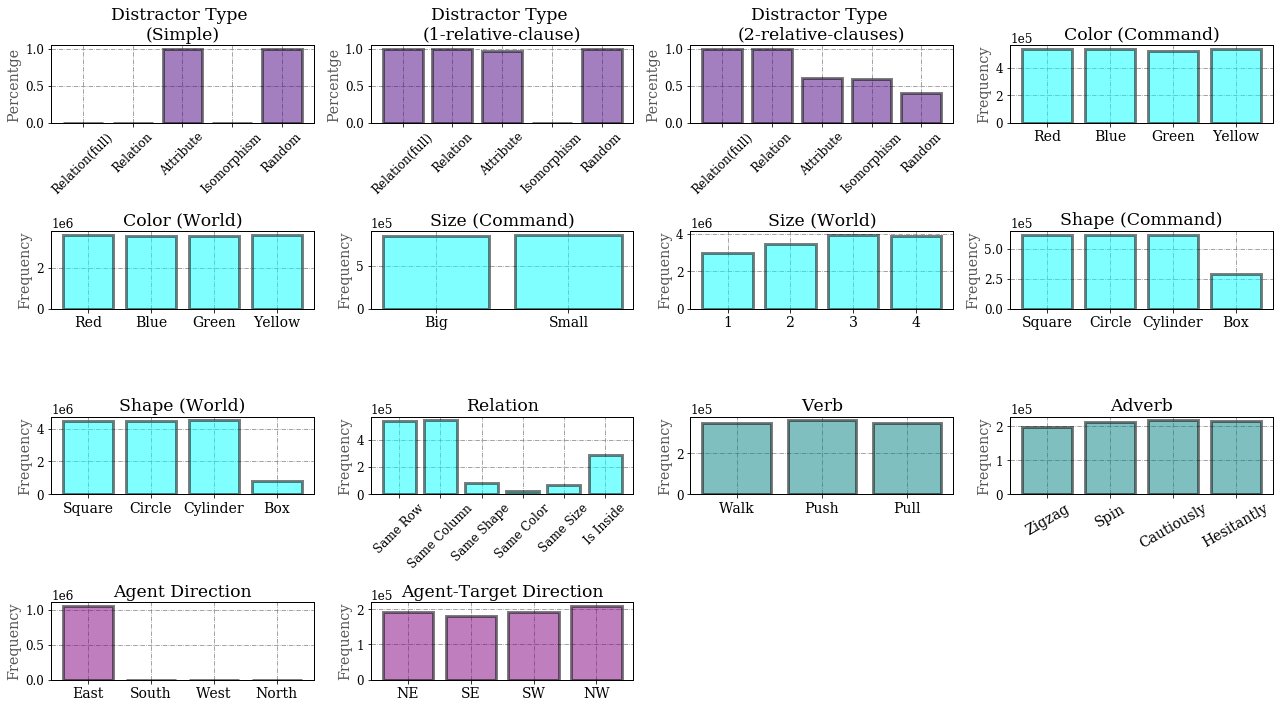

In [86]:
from matplotlib import gridspec
# plt.style.use("ggplot")
plt.rcParams["font.family"] = "DejaVu Serif"
font = {'family' : 'DejaVu Serif',
        'size'   : 12}
plt.rc('font', **font)

with plt.rc_context({'axes.edgecolor':'black', 'xtick.color':'black', 'ytick.color':'black', 'figure.facecolor':'white'}):

    N = 14
    cols = 4
    rows = int(math.ceil(N / cols))

    gs = gridspec.GridSpec(rows, cols)
    fig = plt.figure(figsize=(18,10))

    # a set of plots for distractor type dist
    bar_labels = [k for k, v in p3_d_stats.items()]
    p3_d_v = [v for k, v in p3_d_stats.items()]
    p2_d_v = [v for k, v in p2_d_stats.items()]
    p1_d_v = [v for k, v in p1_d_stats.items()]
    x_pos = list(range(len(bar_labels)))
    ax = fig.add_subplot(gs[0])
    ax.bar(x_pos, p1_d_v, align='center', color="indigo", alpha=0.5, edgecolor='k', linewidth=3)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(bar_labels, rotation = 45, fontsize=12)
    ax.grid(color="white")
    ax.set_ylabel("Percentge")
    ax.set_title("Distractor Type \n(Simple)")
    plt.grid(color='grey', linestyle='-.', linewidth=0.7)
    ax.set_facecolor("white")

    ax = fig.add_subplot(gs[1])
    p2_d_v[1] = p2_d_v[0] # relation full is relation for this case.
    ax.bar(x_pos, p2_d_v, align='center', color="indigo", alpha=0.5, edgecolor='k', linewidth=3)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(bar_labels, rotation = 45, fontsize=12)
    ax.grid(color="white")
    ax.set_title("Distractor Type \n(1-relative-clause)")
    ax.set_ylabel("Percentge")
    plt.grid(color='grey', linestyle='-.', linewidth=0.7)
    ax.set_facecolor("white")

    ax = fig.add_subplot(gs[2])
    ax.bar(x_pos, p3_d_v, align='center', color="indigo", alpha=0.5, edgecolor='k', linewidth=3)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(bar_labels, rotation = 45, fontsize=12)
    ax.grid(color="white")
    ax.set_title("Distractor Type \n(2-relative-clauses)")
    ax.set_ylabel("Percentge")
    plt.grid(color='grey', linestyle='-.', linewidth=0.7)
    ax.set_facecolor("white")

    # a set for color, size and shape
    bar_labels = [k for k, v in command_color_stats.items()]
    color_d_v = [v for k, v in command_color_stats.items()]
    x_pos = list(range(len(bar_labels)))
    ax = fig.add_subplot(gs[3])
    ax.bar(x_pos, color_d_v, align='center', color="cyan", alpha=0.5, edgecolor='k', linewidth=3)
    ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    ax.set_xticks(x_pos)
    ax.set_xticklabels(bar_labels, fontsize=14)
    ax.grid(color="white")
    ax.set_title("Color (Command)")
    ax.set_ylabel("Frequency")
    plt.grid(color='grey', linestyle='-.', linewidth=0.7)
    ax.set_facecolor("white")

    bar_labels = [k for k, v in world_color_stats.items()]
    color_d_v = [v for k, v in world_color_stats.items()]
    x_pos = list(range(len(bar_labels)))
    ax = fig.add_subplot(gs[4])
    ax.bar(x_pos, color_d_v, align='center', color="cyan", alpha=0.5, edgecolor='k', linewidth=3)
    ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    ax.set_xticks(x_pos)
    ax.set_xticklabels(bar_labels, fontsize=14)
    ax.grid(color="white")
    ax.set_title("Color (World)")
    ax.set_ylabel("Frequency")
    plt.grid(color='grey', linestyle='-.', linewidth=0.7)
    ax.set_facecolor("white")

    bar_labels = [k for k, v in command_size_stats.items()]
    color_d_v = [v for k, v in command_size_stats.items()]
    x_pos = list(range(len(bar_labels)))
    ax = fig.add_subplot(gs[5])
    ax.bar(x_pos, color_d_v, align='center', color="cyan", alpha=0.5, edgecolor='k', linewidth=3)
    ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    ax.set_xticks(x_pos)
    ax.set_xticklabels(bar_labels, fontsize=14)
    ax.grid(color="white")
    ax.set_title("Size (Command)")
    ax.set_ylabel("Frequency")
    plt.grid(color='grey', linestyle='-.', linewidth=0.7)
    ax.set_facecolor("white")

    bar_labels = [k for k, v in world_size_stats.items()]
    color_d_v = [v for k, v in world_size_stats.items()]
    x_pos = list(range(len(bar_labels)))
    ax = fig.add_subplot(gs[6])
    ax.bar(x_pos, color_d_v, align='center', color="cyan", alpha=0.5, edgecolor='k', linewidth=3)
    ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    ax.set_xticks(x_pos)
    ax.set_xticklabels(bar_labels, fontsize=14)
    ax.grid(color="white")
    ax.set_title("Size (World)")
    ax.set_ylabel("Frequency")
    plt.grid(color='grey', linestyle='-.', linewidth=0.7)
    ax.set_facecolor("white")

    bar_labels = [k for k, v in command_shape_stats.items()]
    color_d_v = [v for k, v in command_shape_stats.items()]
    x_pos = list(range(len(bar_labels)))
    ax = fig.add_subplot(gs[7])
    ax.bar(x_pos, color_d_v, align='center', color="cyan", alpha=0.5, edgecolor='k', linewidth=3)
    ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    ax.set_xticks(x_pos)
    ax.set_xticklabels(bar_labels, fontsize=14)
    ax.grid(color="white")
    ax.set_title("Shape (Command)")
    ax.set_ylabel("Frequency")
    plt.grid(color='grey', linestyle='-.', linewidth=0.7)
    ax.set_facecolor("white")

    bar_labels = [k for k, v in world_shape_stats.items()]
    color_d_v = [v for k, v in world_shape_stats.items()]
    x_pos = list(range(len(bar_labels)))
    ax = fig.add_subplot(gs[8])
    ax.bar(x_pos, color_d_v, align='center', color="cyan", alpha=0.5, edgecolor='k', linewidth=3)
    ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    ax.set_xticks(x_pos)
    ax.set_xticklabels(bar_labels, fontsize=14)
    ax.grid(color="white")
    ax.set_title("Shape (World)")
    ax.set_ylabel("Frequency")
    plt.grid(color='grey', linestyle='-.', linewidth=0.7)
    ax.set_facecolor("white")

    # relation
    bar_labels = [k for k, v in command_relation_stats.items()]
    color_d_v = [v for k, v in command_relation_stats.items()]
    x_pos = list(range(len(bar_labels)))
    ax = fig.add_subplot(gs[9])
    ax.bar(x_pos, color_d_v, align='center', color="cyan", alpha=0.5, edgecolor='k', linewidth=3)
    ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    ax.set_xticks(x_pos)
    ax.set_xticklabels(bar_labels, rotation = 45, fontsize=12)
    ax.grid(color="white")
    ax.set_title("Relation")
    ax.set_ylabel("Frequency")
    plt.grid(color='grey', linestyle='-.', linewidth=0.7)
    ax.set_facecolor("white")

    # verb
    bar_labels = [k for k, v in command_verb_stats.items()]
    color_d_v = [v for k, v in command_verb_stats.items()]
    x_pos = list(range(len(bar_labels)))
    ax = fig.add_subplot(gs[10])
    ax.bar(x_pos, color_d_v, align='center', color="teal", alpha=0.5, edgecolor='k', linewidth=3)
    ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    ax.set_xticks(x_pos)
    ax.set_xticklabels(bar_labels, fontsize=14)
    ax.grid(color="white")
    ax.set_title("Verb")
    ax.set_ylabel("Frequency")
    plt.grid(color='grey', linestyle='-.', linewidth=0.7)
    ax.set_facecolor("white")

    # adverb
    bar_labels = [k for k, v in command_adverb_stats.items()]
    color_d_v = [v for k, v in command_adverb_stats.items()]
    x_pos = list(range(len(bar_labels)))
    ax = fig.add_subplot(gs[11])
    ax.bar(x_pos, color_d_v, align='center', color="teal", alpha=0.5, edgecolor='k', linewidth=3)
    ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    ax.set_xticks(x_pos)
    ax.set_xticklabels(bar_labels, rotation = 30, fontsize=14)
    ax.grid(color="white")
    ax.set_title("Adverb")
    ax.set_ylabel("Frequency")
    plt.grid(color='grey', linestyle='-.', linewidth=0.7)
    ax.set_facecolor("white")

    # agency
    bar_labels = [k for k, v in world_agent_dir_stats.items()]
    color_d_v = [v for k, v in world_agent_dir_stats.items()]
    x_pos = list(range(len(bar_labels)))
    ax = fig.add_subplot(gs[12])
    ax.bar(x_pos, color_d_v, align='center', color="purple", alpha=0.5, edgecolor='k', linewidth=3)
    ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    ax.set_xticks(x_pos)
    ax.set_xticklabels(bar_labels, fontsize=14)
    ax.grid(color="white")
    ax.set_title("Agent Direction")
    ax.set_ylabel("Frequency")
    plt.grid(color='grey', linestyle='-.', linewidth=0.7)
    ax.set_facecolor("white")

    bar_labels = [k for k, v in world_agent_target_dir_stats.items()]
    color_d_v = [v for k, v in world_agent_target_dir_stats.items()]
    x_pos = list(range(len(bar_labels)))
    ax = fig.add_subplot(gs[13])
    ax.bar(x_pos, color_d_v, align='center', color="purple", alpha=0.5, edgecolor='k', linewidth=3)
    ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    ax.set_xticks(x_pos)
    ax.set_xticklabels(bar_labels, fontsize=14)
    ax.grid(color="white")
    ax.set_title("Agent-Target Direction")
    ax.set_ylabel("Frequency")
    plt.grid(color='grey', linestyle='-.', linewidth=0.7)
    ax.set_facecolor("white")
    fig.tight_layout()
    
    # plt.show()
    plt.savefig("../../data-files-updated/Analysis-Result/artifacts",dpi=1000, bbox_inches='tight')

This is for one bug found in the ReaSCAN, where we actually did not activately making sure both relations are necessary.

In [389]:
# SCAN through the dataset and get the number of when both relations matter.
p3_path_to_data = "../../data-files/ReaSCAN-compositional-p3/data-train.txt"
logger.info(f"Reading dataset from file: {p3_path_to_data}...")
p3_data_json = json.load(open(p3_path_to_data, "r"))

2021-05-29 23:30 Reading dataset from file: ../../data-files/ReaSCAN-compositional-p3/data-train.txt...


In [ ]:
both_required_count = 0
total_example_count = 0
examples = p3_data_json["examples"]["train"]
random.shuffle(examples)
for example in examples:
    
    objects = OrderedDict({})
    object_patterns = example['object_pattern_map']
    vocabulary = vocabulary
    positions = OrderedDict({})
    referred_object = "$OBJ_0"

    obj_count = len(example["situation"]["placed_objects"])
    for i in range(0, obj_count):
        obj_key = f"$OBJ_{i}"
        obj_to_convert = example["situation"]["placed_objects"][f"{i}"]
        objects[obj_key] = Object(size=obj_to_convert['object']['size'], 
                                  color=obj_to_convert['object']['color'], 
                                  shape=obj_to_convert['object']['shape'])
        positions[obj_key] = Position(column=obj_to_convert['position']['column'],
                                      row=obj_to_convert['position']['row'],)
    graph = ReaSCANGraph(
        objects=objects, 
        object_patterns=object_patterns, 
        vocabulary=vocabulary,
        positions=positions, 
        referred_object=referred_object,
        debug=False
    )

    # Now let us remove 1 edge.
    serialized_relations = OrderedDict({})
    objects_pattern = OrderedDict({})
    relation_pair = example['relation_map'][1]

    serialized_relations[('$OBJ_0', '$OBJ_1')] = relation_pair[1]
    objects_pattern['$OBJ_0'] = example['object_expression']['$OBJ_0']
    objects_pattern['$OBJ_1'] = example['object_expression']['$OBJ_2']
    pattern_graph = ReaSCANGraph(
        objects=objects_pattern, 
        object_patterns=None,
        vocabulary=vocabulary,
        relations=serialized_relations, 
        referred_object='$OBJ_0', 
        debug=False
    )

    potential_referent_target_case_1 = graph.find_referred_object_super_fast(
        pattern_graph, referred_object='$OBJ_0', 
        debug=False
    )

    # Let us remove another edge.
    serialized_relations = OrderedDict({})
    objects_pattern = OrderedDict({})
    relation_pair = example['relation_map'][0]

    serialized_relations[('$OBJ_0', '$OBJ_1')] = relation_pair[1]
    objects_pattern['$OBJ_0'] = example['object_expression']['$OBJ_0']
    objects_pattern['$OBJ_1'] = example['object_expression']['$OBJ_1']
    pattern_graph = ReaSCANGraph(
        objects=objects_pattern, 
        object_patterns=None,
        vocabulary=vocabulary,
        relations=serialized_relations, 
        referred_object='$OBJ_0', 
        debug=False
    )

    potential_referent_target_case_2 = graph.find_referred_object_super_fast(
        pattern_graph, referred_object='$OBJ_0', 
        debug=False
    )
    total_example_count += 1
    if len(potential_referent_target_case_1) != 1 and len(potential_referent_target_case_2) != 1:
        both_required_count += 1
    if total_example_count % 1000 == 0:
        print(f"{both_required_count}/{total_example_count}")
        p = both_required_count*100.0/total_example_count
        print(f"percentage={p}%")

Make a small demo file for ReaSCAN

In [244]:
demo_train = ReaSCAN_data_json["examples"]['train'][:2000]
demo_test = ReaSCAN_data_json["examples"]['test'][:200]
demo_dev = ReaSCAN_data_json["examples"]['dev'][:200]
ReaSCAN_data_json["examples"] = {}
ReaSCAN_data_json["examples"]["train"] = demo_train
ReaSCAN_data_json["examples"]["test"] = demo_test
ReaSCAN_data_json["examples"]["dev"] = demo_dev

In [245]:
with open("../../data-files/ReaSCAN-demo/data-compositional-splits.txt", "w") as fd:
    json.dump(ReaSCAN_data_json, fd, indent=4)

Random baseline

In [379]:
condition = "-p4-test"

path_to_data = f"../../data-files/ReaSCAN-compositional{condition}/data-compositional-splits.txt"
logger.info(f"Reading dataset from file: {path_to_data}...")
data_json = json.load(open(path_to_data, "r"))

2021-05-28 16:44 Reading dataset from file: ../../data-files/ReaSCAN-compositional-p4-test/data-compositional-splits.txt...


In [380]:
# random generate output sequence based on target vocab
# vocab = json.load(open(f"../../data-files/ReaSCAN-compositional-{condition}/target_vocabulary.txt", "r"))
vocab = ['turn left', 'turn right', 'walk', 'push', 'stay', 'pull']

In [385]:
# dev
seed = 44

random.seed(seed)
target_actions = []
random_actions = []
for example in data_json["examples"]["test"]:
    target_action = example['target_commands']
    action_len = len(target_action.split(","))
    random_action = []
    for i in range(action_len):
        random_action += [random.choice(vocab)]
    target_actions.append(target_action)
    random_actions.append(",".join(random_action))

In [386]:
exact_match_c = 0
for i in range(len(target_actions)):
    if target_actions[i] == random_actions[i]:
        exact_match_c += 1
exact_match_p = exact_match_c/len(target_actions)
print(f"random exact match%={exact_match_p*100.}")

random exact match%=0.05982650314089141


### Data browser
This section will generate data that our data browser needed to display the dataset.

In [188]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
plt.rcParams["font.family"] = "DejaVu Serif"
font = {'family' : 'DejaVu Serif'}
plt.rc('font', **font)

example_count = 0
metadata_json = OrderedDict({})
all_metadata = []

In [196]:
pattern = "p3"
ReaSCAN_data_file = f"ReaSCAN-compositional-{pattern}/data-compositional-splits.txt"
ReaSCAN_data_json = json.load(open(os.path.join("../../data-files-updated/", ReaSCAN_data_file)))

In [197]:
for i in range(0, 100):
    index = example_count
    if index % 20 == 0:
        print(f"saving example #{index}")
    example = ReaSCAN_data_json["examples"]["train"][random.randint(0, len(ReaSCAN_data_json["examples"]["train"])-1)]
    command = " ".join(example["command"].split(","))
    action_sequence = example["target_commands"]

    situation = example["situation"]
    world = World(grid_size=6, colors=vocabulary.get_semantic_colors(),
                  object_vocabulary=object_vocabulary,
                  shapes=vocabulary.get_semantic_shapes(),
                  save_directory="./tmp/")
    world.clear_situation()
    for obj_idx, obj in situation["placed_objects"].items():
        world.place_object(
            Object(size=int(obj["object"]["size"]), color=obj["object"]["color"], shape=obj["object"]["shape"]), 
            position=Position(row=int(obj["position"]["row"]), column=int(obj["position"]["column"]))
        )
    world.place_agent_at(
        Position(
            row=int(situation["agent_position"]["row"]), 
            column=int(situation["agent_position"]["column"])
    ))
    world_array = world.render_simple(array_only=True)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.imshow(world_array)
    plt.xticks([])
    plt.yticks([])
    fig.savefig(
        f"../../data-files-updated/data-browser-examples/{index}-no-target.png", 
        dpi=500, bbox_inches='tight'
    )
    plt.close(fig)

    row = int(example['situation']['target_object']['position']['row'])
    col = int(example['situation']['target_object']['position']['column'])
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.imshow(world_array)
    ax.add_patch(
        patches.Rectangle(
            xy=(col*60, row*60),  # point of origin.
            width=60,
            height=60,
            linewidth=3,
            color='brown',
            fill=False,
            alpha=1,
            hatch="/",
            linestyle="--"
        )
    )
    ax.text(col*60, (row+1)*60+20, "Target", fontsize=11, color="black")
    plt.xticks([])
    plt.yticks([])
    fig.savefig(
        f"../../data-files-updated/data-browser-examples/{index}-target.png", 
        dpi=500, bbox_inches='tight'
    )
    plt.close(fig)
    
    example_metadata = {
        "pattern": pattern,
        "command": command, 
        "action_sequence": action_sequence,
        "no_target_img_name": f"{index}-no-target.png",
        "target_img_name": f"{index}-target.png",
    }
    all_metadata += [example_metadata]
    example_count += 1

saving example #60
saving example #80
saving example #100
saving example #120
saving example #140


In [199]:
with open("../../data-files-updated/data-browser-examples/metadata.json", "w") as fd:
    json.dump(all_metadata, fd, indent=4)

### Some Countings used in the paper

In [9]:
external_data_dir = "../../data-files-updated/"
ReaSCAN_data_file = "ReaSCAN-compositional/data-compositional-splits.txt"
ReaSCAN_data_json = json.load(open(os.path.join(external_data_dir, ReaSCAN_data_file)))

In [50]:
count = 0
for example in ReaSCAN_data_json["examples"]['train']:
    for k, v in example['situation']['placed_objects'].items():
        if v['object']['color'] == "yellow" and v['object']['shape'] == "square":
            count += 1
            break
count

313153

In [40]:
sum(cc)/len(cc)

2.7621828512804325

In [37]:
count

25404

### gSCAN Analyses

In [8]:
gSCAN_data_file = "gSCAN-compositional_splits/dataset.txt"
gSCAN_data_json = json.load(open(os.path.join(external_data_dir, gSCAN_data_file)))

In [9]:
# Data splits
for split_name, examples in gSCAN_data_json["examples"].items():
    print(f"SPLIT: {split_name}, COUNT: {len(examples)}")

SPLIT: train, COUNT: 367933
SPLIT: dev, COUNT: 3716
SPLIT: test, COUNT: 19282
SPLIT: visual, COUNT: 37436
SPLIT: situational_1, COUNT: 88642
SPLIT: situational_2, COUNT: 16808
SPLIT: contextual, COUNT: 11460
SPLIT: adverb_1, COUNT: 112880
SPLIT: adverb_2, COUNT: 38582
SPLIT: visual_easier, COUNT: 18718
